In [213]:
from __future__ import unicode_literals, print_function, division

import os
from io import open
import sys
import math
import random
import argparse
import operator
import pdb

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


from collections import defaultdict
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Kyle's attempt
import faker
from faker import Faker
import pandas as pd
import numpy as np
import re
from string import punctuation
import glob
import unicodedata
import string
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fake = Faker()

In [214]:
class LSTMClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(LSTMClassifier, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1)

        self.hidden2out = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        self.dropout_layer = nn.Dropout(p=0.2)


    def init_hidden(self, batch_size):
        return(autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)),
                    autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)))


    def forward(self, batch, lengths):

        self.hidden = self.init_hidden(batch.size(-1))

        embeds = self.embedding(batch)
        packed_input = pack_padded_sequence(embeds, lengths)
        outputs, (ht, ct) = self.lstm(packed_input, self.hidden)
        # ht is the last hidden state of the sequences
        # ht = (1 x batch_size x hidden_dim)
        # ht[-1] = (batch_size x hidden_dim)
        output = self.dropout_layer(ht[-1])
        output = self.hidden2out(output)
        output = self.softmax(output)

        return output

In [215]:
        
class PaddedTensorDataset(Dataset):
#     """Dataset wrapping data, target and length tensors.

#     Each sample will be retrieved by indexing both tensors along the first
#     dimension.

#     Arguments:
#         data_tensor (Tensor): contains sample data.
#         target_tensor (Tensor): contains sample targets (labels).
#         length (Tensor): contains sample lengths.
#         raw_data (Any): The data that has been transformed into tensor, useful for debugging
#     """

    def __init__(self, data_tensor, target_tensor, length_tensor, raw_data):
        assert data_tensor.size(0) == target_tensor.size(0) == length_tensor.size(0)
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
        self.length_tensor = length_tensor
        self.raw_data = raw_data

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index], self.length_tensor[index], self.raw_data[index]

    def __len__(self):
        return self.data_tensor.size(0)

In [300]:
class DF_To_Tensors():
    def __init__(self):
        self.tag2id = defaultdict(int,
                        {'city': 0,
                         'first_name': 1,
                         'geo': 2,
                         'percent': 3,
                         'year': 4,
                         'date': 5,
                         'ssn': 6,
                         'language_name': 7,
                         'country': 8,
                         'phone_number': 9,
                         'month': 10,
                         'zipcode': 11,
                         'iso8601': 12,
                         'paragraph': 13,
                         'pyfloat': 14,
                         'email': 15,
                         'prefix': 16,
                         'pystr': 17,
                         'isbn': 18,
                         'boolean': 19,
                        'country_code': 20,
                        'continent':21})
        self.n_categories = len(self.tag2id)
        self.token_set={'a','b','c','d','e',
                        'f','g','h','i','j','k','l',
                        'm','n','o','p','q','r','s',
                        't','u','v','w','x','y','z',
                        'A','B','C','D','E','F','G',
                        'H','I','J','K','L','M','N',
                        'O','P','Q','R','S','T','U',
                        'V','W','X','Y','Z','1','2',
                        '3','4','5','6','7','8','9','0',
                        "'",',','.',';','*','!','@',
                        '#','$','%','^','&','(',')',
                        '_','=','-',':','+','/',"\\", '*'}
        self.token2id = defaultdict(int,
            {'PAD': 0,
             'UNK': 1,
             'a':2,
             'b':3,
             'c': 4,
             'd': 5,
             'e': 6,
             'f': 7,
             'g':8,
             'h': 9,
             'i': 10,
             'j':11,
             'k':12,
             'l':13,
             'm':14,
             'n':15,
             'o':16,
             'p':17,
             'q':18,
             'r':19,
             's':20,
             't':21,
             'u':22,
             'v':23,
             'w':24,
             'x':25,
             'y':26,
             'z':27,
             'A':28,
             'B':29,
             'C':30,
             'D':31,
             'E':32,
             'F':33,
             'G':34,
             'H':35,
             'I':36,
             'J':37,
             'K':38,
             'L':39,
             'N':40,
             'O':41,
             'P':42,
             'Q':43,
             'R':44,
             'S':45,
             'T':46,
             'U':47,
             'V':48,
             'W':49,
             'X':50,
             'Y':51,
             'Z':52,
             '1':53,
             '2':54,
             '3':55,
             '4':56,
             '5':57,
             '6':58,
             '7':59,
             '8':60,
             '9':61,
             '0':62,
             "'":63,
             ',':64,
             '.':65,
             ';':66,
             '*':67,
             '!':68,
             '@':68,
             '#':70,
             '$':71,
             '%':72,
             '^':73,
             '&':74,
             '(':75,
             ')':76,
             '_':77,
             '=':78,
             '-':79,
             ':':80,
             '+':81,
             '/':82,
             '\\':83,
             '*': 84})
    
    def vectorized_string(self, string):
            return [self.token2id[token] if token in self.token2id else self.token2id['UNK'] for token in str(string)]
        
    def vectorized_array(self, array):
        vecorized_array=[]
        for stringValue in array:
            vecorized_array.append(self.vectorized_string(stringValue))
        return vecorized_array
    
    def pad_sequences(self, vectorized_seqs, seq_lengths):
        # create a zero matrix
        seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()

        # fill the index
        for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
            seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
        return seq_tensor


    def create_dataset(self, data, batch_size=1):
        vectorized_seqs = self.vectorized_array(data)
        seq_lengths = torch.LongTensor([len(s) for s in vectorized_seqs])
        seq_tensor = self.pad_sequences(vectorized_seqs, seq_lengths)
        target_tensor = torch.LongTensor([self.tag2id[y] for  y in data])
        raw_data = [x for x in data]
        
        return DataLoader(PaddedTensorDataset(seq_tensor, target_tensor, seq_lengths, raw_data), batch_size=batch_size)

    def sort_batch(self,batch, targets, lengths):
        seq_lengths, perm_idx = lengths.sort(0, descending=True)
        seq_tensor = batch[perm_idx]
        target_tensor = targets[perm_idx]

        return seq_tensor.transpose(0, 1), target_tensor, seq_lengths


    def evaluate_test_set(self, model, test):
        y_pred = list()
        all_predictionsforValue=[]

        for batch, targets, lengths, raw_data in self.create_dataset(test, batch_size=1):
            batch, targets, lengths = self.sort_batch(batch, targets, lengths)
            pred = model(torch.autograd.Variable(batch), lengths.cpu().numpy())
            pred_idx = torch.max(pred, 1)[1]
            print('pred_idx', pred_idx)
            def get_key(val):
                for key, value in self.tag2id.items():
                     if val == value:
                            print(key)
                            return {'key':key, 'tensor':pred, 'pred_idx':pred_idx}
#                             all_predictionsforValue.append({'key':key, 'tensor':pred, 'pred_idx':pred_idx})

            all_predictionsforValue.append(get_key(pred_idx[0]))
        return all_predictionsforValue
        
    def read_in_csv(self,path):
        self.df = pd.read_csv(path)
#         print(self.df.head())
    
    def get_arrayOfValues_df(self):
        import time
        column_value_object={}

        for column in self.df.columns:
            guesses=[]
            column_value_object[column]=[]
            for _ in range(1,3):
                random_values = str(np.random.choice(self.df[column]))
                random_col = column
                column_value_object[column].append(str(random_values)) 

        return column_value_object
    
    def predictions(self, model, path_to_csv):
        self.read_in_csv(path=path_to_csv)
        column_value_object = self.get_arrayOfValues_df()
        for column in column_value_object:
            print(column_value_object[column])
            print(column)
            print(self.evaluate_test_set(model, column_value_object[column]))
#             return {
#                 'column': column,
#                 'values': column_value_object[column],
#                 'predictions': self.evaluate_test_set(column_value_object[column])
#             }
        


In [301]:
dft_tensor=DF_To_Tensors()

In [302]:
dft_tensor.predictions(model=model, path_to_csv='datasets/data/africa_test.csv')

['9', '62']
fid
pred_idx tensor([10])
month
pred_idx tensor([10])
month
[{'key': 'month', 'tensor': tensor([[ -9.1094,  -8.7308, -11.3391,  -7.1530,  -2.4749,  -8.6563, -10.3372,
          -6.5487,  -6.9306,  -9.6534,  -0.0952,  -7.1592,  -7.1203, -12.4342,
         -11.5027,  -8.4584, -14.8339,  -7.0034, -13.0112,  -8.8641, -10.6496,
         -11.9502]], grad_fn=<LogSoftmaxBackward>), 'pred_idx': tensor([10])}, {'key': 'month', 'tensor': tensor([[-10.3968, -12.6856, -11.2375,  -3.2243,  -6.1149,  -8.7742, -10.0740,
         -12.5219, -10.7765,  -8.8796,  -0.0447,  -7.7015,  -8.1269, -12.3641,
          -8.3840,  -8.2342, -13.3144, -12.8959, -14.9854, -10.9250, -13.3443,
         -13.6987]], grad_fn=<LogSoftmaxBackward>), 'pred_idx': tensor([10])}]
['Nigeria', 'Egypt']
CNTRY_NAME
pred_idx tensor([8])
country
pred_idx tensor([8])
country
[{'key': 'country', 'tensor': tensor([[ -6.6918,  -1.8603, -16.6918, -15.7124, -14.3774, -14.6091, -13.5892,
          -1.6912,  -0.4659, -10.7059, -11

In [303]:
dft_tensor.predictions(model=model, path_to_csv='datasets/data/four_col_test.csv')

['GNQ', 'LBN']
iso3
pred_idx tensor([20])
country_code
pred_idx tensor([20])
country_code
[{'key': 'country_code', 'tensor': tensor([[ -7.9046,  -5.3461,  -9.3440,  -8.0352,  -8.8166, -10.8524,  -9.6658,
          -8.6154,  -1.2662, -11.1694,  -6.8172,  -9.9263,  -8.2822,  -8.7585,
          -9.6369,  -7.4182,  -6.1559,  -4.1241,  -9.3724, -10.6283,  -0.3728,
          -5.9162]], grad_fn=<LogSoftmaxBackward>), 'pred_idx': tensor([20])}, {'key': 'country_code', 'tensor': tensor([[-11.4851,  -7.5697,  -8.8199,  -8.2626,  -9.7715, -12.4979, -10.9499,
          -8.9976,  -2.2257, -11.7737,  -9.7015, -10.4109,  -7.7127,  -9.8732,
          -9.6917,  -8.9377,  -6.0738,  -5.7414, -12.4200, -10.6592,  -0.1293,
          -5.1373]], grad_fn=<LogSoftmaxBackward>), 'pred_idx': tensor([20])}]
['Belarus', 'Latvia']
Country.x
pred_idx tensor([8])
country
pred_idx tensor([8])
country
[{'key': 'country', 'tensor': tensor([[ -5.5669,  -1.3858, -10.7392, -10.7534, -11.4851, -10.3595,  -9.2499,
          

In [272]:
model = torch.load('/home/kyle/code/pytorch_plural/models/LSTM_RNN_classifier_model_5.pth')
model.eval()

LSTMClassifier(
  (embedding): Embedding(84, 128)
  (lstm): LSTM(128, 32)
  (hidden2out): Linear(in_features=32, out_features=22, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout_layer): Dropout(p=0.2, inplace=False)
)

In [222]:
dft_tensor.evaluate_test_set(model=model,test=['01/02/2020', '09', 'USA', 'WOWOOWOWOWOWOWOWO', '1999', '1200', '402', '.3934', 'iiii', '12', 'USA',"ETH",'South America'])

date
month
continent
pystr
year
year
year
geo
language_name
month
continent
country_code
continent


In [41]:
def randomChoice(self, values):
    return values[random.randint(0, len(values) - 1)]

def getRandomSet(self):
    category = self.randomChoice(self.all_categories)
#         print(category)
    line = self.randomChoice(list(self.category_values[category]['obj']))
#         print('line', line)
    return (line, category)

In [117]:
## load example df

In [42]:
data = pd.read_csv('datasets/data/africa_test.csv')

In [43]:
data.head(10)

,fid,CNTRY_NAME,AREA,CAPNAME,CAPLONG,CAPLAT,FEATUREID,COWCODE,COWSYEAR,COWSMONTH,...,GWSYEAR,GWSMONTH,GWSDAY,GWEYEAR,GWEMONTH,GWEDAY,ISONAME,ISO1NUM,ISO1AL2,ISO1AL3
0,1,Cote d'Ivoire,3.234122e+05,Yamoussoukro,-5.283333,6.816667,40,437,1960,8,...,1960,8,7,2016,6,30,Cote d'Ivoire,384,CI,CIV
1,2,Ghana,2.405855e+05,Accra,-0.216667,5.550000,41,452,1957,3,...,1957,3,6,2016,6,30,Ghana,288,GH,GHA
2,3,Liberia,9.663452e+04,Monrovia,-10.800000,6.310555,42,450,1946,1,...,1946,1,1,2016,6,30,Liberia,430,LR,LBR
3,4,Morocco,4.014448e+05,Rabat,-6.830000,34.020000,43,600,1956,3,...,1956,3,2,1958,3,31,NaN,0,NaN,NaN
4,5,Burkina Faso,2.740095e+05,Ouagadougou,-1.524722,12.370280,46,439,1960,8,...,1960,8,5,2016,6,30,Burkina Faso,854,BF,BFA
5,6,Guinea,2.465947e+05,Conakry,-13.700000,9.509167,47,438,1958,10,...,1958,10,2,2016,6,30,Guinea,324,GN,GIN
6,7,Guinea-Bissau,3.346212e+04,Bissau,-15.600000,11.850000,48,404,1974,9,...,1974,9,10,2016,6,30,Guinea-Bissau,624,GW,GNB
7,8,Mali,1.259195e+06,Bamako,-8.000000,12.650000,49,432,1960,8,...,1960,9,22,2016,6,30,Mali,466,ML,MLI
8,9,Mauritania,1.043783e+06,Nouakchott,-16.000000,18.119440,50,435,1960,11,...,1960,11,28,1976,3,31,Mauritania,478,MR,MRT
9,10,Senegal,1.971726e+05,Dakar,-17.500000,14.708890,51,433,1960,8,...,1960,4,4,2016,6,30,Senegal,686,SN,SEN


In [121]:
data.columns

Index(['fid', 'CNTRY_NAME', 'AREA', 'CAPNAME', 'CAPLONG', 'CAPLAT',
       'FEATUREID', 'COWCODE', 'COWSYEAR', 'COWSMONTH', 'COWSDAY', 'COWEYEAR',
       'COWEMONTH', 'COWEDAY', 'GWCODE', 'GWSYEAR', 'GWSMONTH', 'GWSDAY',
       'GWEYEAR', 'GWEMONTH', 'GWEDAY', 'ISONAME', 'ISO1NUM', 'ISO1AL2',
       'ISO1AL3'],
      dtype='object')

In [50]:
import time
final={}

for column in data.columns:
    print(column)
    guesses=[]
    final[column]=[]
    for _ in range(1,3):
        random_values = str(np.random.choice(data[column]))
        random_col = column
        print(str(random_values), str(random_col))
        final[column].append((str(random_values),str(random_col))) 
#         example = lineToTensor(random_values)
#         o=evaluate(example)
#         guess, guess_i = categoryFromOutput(o)
#         guesses.append(guess[0])
#         print(guess, guess_i, 'column name', random_col)
#     final[random_col]=guesses
print(final)

fid
22 fid
67 fid
CNTRY_NAME
Seychelles CNTRY_NAME
South Sudan CNTRY_NAME
AREA
246594.677066 AREA
914291.337152 AREA
CAPNAME
Dar es Salaam CAPNAME
Tripoli CAPNAME
CAPLONG
-15.6 CAPLONG
32.56556 CAPLONG
CAPLAT
-8.838333 CAPLAT
9.033333 CAPLAT
FEATUREID
201 FEATUREID
173 FEATUREID
COWCODE
520 COWCODE
560 COWCODE
COWSYEAR
1964 COWSYEAR
1962 COWSYEAR
COWSMONTH
9 COWSMONTH
7 COWSMONTH
COWSDAY
14 COWSDAY
18 COWSDAY
COWEYEAR
2016 COWEYEAR
2016 COWEYEAR
COWEMONTH
6 COWEMONTH
6 COWEMONTH
COWEDAY
30 COWEDAY
30 COWEDAY
GWCODE
696 GWCODE
530 GWCODE
GWSYEAR
1971 GWSYEAR
1960 GWSYEAR
GWSMONTH
6 GWSMONTH
4 GWSMONTH
GWSDAY
-1 GWSDAY
21 GWSDAY
GWEYEAR
2016 GWEYEAR
2016 GWEYEAR
GWEMONTH
6 GWEMONTH
3 GWEMONTH
GWEDAY
30 GWEDAY
30 GWEDAY
ISONAME
Eritrea ISONAME
Egypt ISONAME
ISO1NUM
678 ISO1NUM
0 ISO1NUM
ISO1AL2
ER ISO1AL2
MR ISO1AL2
ISO1AL3
MWI ISO1AL3
LBY ISO1AL3
{'fid': [('22', 'fid'), ('67', 'fid')], 'CNTRY_NAME': [('Seychelles', 'CNTRY_NAME'), ('South Sudan', 'CNTRY_NAME')], 'AREA': [('246594.677066',

In [100]:
char_vocab = defaultdict(int,
            {'PAD': 0,
             'UNK': 1,
             'z': 2,
             'V': 3,
             '^': 4,
             '9': 5,
             'g': 6,
             '8': 7,
             'C': 8,
             'S': 9,
             '+': 10,
             '&': 11,
             'N': 12,
             'w': 13,
             'O': 14,
             '1': 15,
             "'": 16,
             'p': 17,
             'q': 18,
             'y': 19,
             'o': 20,
             '!': 21,
             '3': 22,
             'n': 23,
             ',': 24,
             'v': 25,
             'c': 26,
             'e': 27,
             '%': 28,
             'd': 29,
             '5': 30,
             'L': 31,
             'J': 32,
             'P': 33,
             '7': 34,
             'X': 35,
             'R': 36,
             '4': 37,
             'M': 38,
             '*': 39,
             '/': 40,
             'H': 41,
             '@': 42,
             's': 43,
             'f': 44,
             'I': 45,
             '(': 46,
             '.': 47,
             'Z': 48,
             'b': 49,
             'K': 50,
             '=': 51,
             'j': 52,
             'D': 53,
             'Q': 54,
             ':': 55,
             'l': 56,
             '#': 57,
             'k': 58,
             'G': 59,
             '-': 60,
             '$': 61,
             'A': 62,
             'a': 63,
             'Y': 64,
             'T': 65,
             't': 66,
             'm': 67,
             '2': 68,
             'h': 69,
             'r': 70,
             '6': 71,
             'i': 72,
             'W': 73,
             'U': 74,
             ';': 75,
             '0': 76,
             'u': 77,
             'E': 78,
             'B': 79,
             '_': 80,
             'F': 81,
             ')': 82,
             'x': 83})

In [74]:
all_categories

array(['paragraph', 'first_name', 'prefix', 'city', 'year', 'isbn',
       'pystr', 'geo', 'boolean', 'phone_number', 'ssn', 'zipcode',
       'date', 'pyfloat', 'month', 'percent', 'language_name', 'email',
       'country', 'iso8601'], dtype='<U13')

In [104]:

def categoryFromOutput(output, ytoix):
    top_n, top_i = output.topk(2)
    print('top_n', top_n,'top_i',top_i)
    print('ytoix', ytoix)
    ac =[]
    ci =[]
    for out in top_i[0]:
        print(out.item())
        category_i = out.item()
        print(category_i, 'category_i')
        print(ytoix[category_i], 'best guess')
        ac.append(ytoix[category_i])
        ci.append(category_i)
    
    return ac, ci

In [170]:
char_vocab=defaultdict(int,{'PAD': 0,
             'UNK': 1,
             'z': 2,
             'V': 3,
             '^': 4,
             '9': 5,
             'g': 6,
             '8': 7,
             'C': 8,
             'S': 9,
             '+': 10,
             '&': 11,
             'N': 12,
             'w': 13,
             'O': 14,
             '1': 15,
             "'": 16,
             'p': 17,
             'q': 18,
             'y': 19,
             'o': 20,
             '!': 21,
             '3': 22,
             'n': 23,
             ',': 24,
             'v': 25,
             'c': 26,
             'e': 27,
             '%': 28,
             'd': 29,
             '5': 30,
             'L': 31,
             'J': 32,
             'P': 33,
             '7': 34,
             'X': 35,
             'R': 36,
             '4': 37,
             'M': 38,
             '*': 39,
             '/': 40,
             'H': 41,
             '@': 42,
             's': 43,
             'f': 44,
             'I': 45,
             '(': 46,
             '.': 47,
             'Z': 48,
             'b': 49,
             'K': 50,
             '=': 51,
             'j': 52,
             'D': 53,
             'Q': 54,
             ':': 55,
             'l': 56,
             '#': 57,
             'k': 58,
             'G': 59,
             '-': 60,
             '$': 61,
             'A': 62,
             'a': 63,
             'Y': 64,
             'T': 65,
             't': 66,
             'm': 67,
             '2': 68,
             'h': 69,
             'r': 70,
             '6': 71,
             'i': 72,
             'W': 73,
             'U': 74,
             ';': 75,
             '0': 76,
             'u': 77,
             'E': 78,
             'B': 79,
             '_': 80,
             'F': 81,
             ')': 82,
             'x': 83})
tag_vocab=defaultdict(int,{'country': 0,
             'first_name': 1,
             'iso8601': 2,
             'phone_number': 3,
             'isbn': 4,
             'language_name': 5,
             'pystr': 6,
             'zipcode': 7,
             'year': 8,
             'percent': 9,
             'city': 10,
             'ssn': 11,
             'month': 12,
             'boolean': 13,
             'date': 14,
             'paragraph': 15,
             'email': 16,
             'geo': 17,
             'prefix': 18,
             'pyfloat': 19})

In [169]:
# for x in final:
#     print(final[x])

def vectorized_data(data, item2id):
    print("item2id", item2id)
    return [[item2id[token] if token in item2id else item2id['UNK'] for token in str(seq)] for seq, _ in data]


def pad_sequences(vectorized_seqs, seq_lengths):
    # create a zero matrix
    seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()

    # fill the index
    for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    return seq_tensor


def create_dataset(data, char_vocab, tag_vocab, batch_size=1):
    vectorized_seqs = vectorized_data(data, char_vocab)
    seq_lengths = torch.LongTensor([len(s) for s in vectorized_seqs])
   

    seq_tensor = pad_sequences(vectorized_seqs, seq_lengths)
    
    target_tensor = torch.LongTensor([tag_vocab[y] for _, y in data])
    print("tar_tensor", target_tensor)
    raw_data = [x for x, _ in data]

    return DataLoader(PaddedTensorDataset(seq_tensor, target_tensor, seq_lengths, raw_data), batch_size=batch_size)


def sort_batch(batch, targets, lengths):
    seq_lengths, perm_idx = lengths.sort(0, descending=True)
    seq_tensor = batch[perm_idx]
    target_tensor = targets[perm_idx]

    return seq_tensor.transpose(0, 1), target_tensor, seq_lengths

def evaluate_test_set(model, test, char_vocab, tag_vocab):
    y_true = list()
    y_pred = list()
#     print('tag_v', tag_vocab)

    for batch, targets, lengths, raw_data in create_dataset(test, char_vocab, tag_vocab, batch_size=1):
#         print('tag_vocab', tag_vocab)

#         print('batch',batch, targets, lengths, raw_data)
        batch, targets, lengths = sort_batch(batch, targets, lengths)
        print('finalbatch', batch)

        pred = model(torch.autograd.Variable(batch), lengths.cpu().numpy())
#         print(pred, 'pred')
        pred_idx = torch.max(pred, 1)[1]
#         print("pred_idx", pred_idx)
#         a, e = categoryFromOutput(pred, tag_vocab)
#         print(a, 'a')
#         print(e, 'e')


In [171]:
evaluate_test_set(model,final['COWSMONTH'], char_vocab, tag_vocab)


item2id defaultdict(<class 'int'>, {'PAD': 0, 'UNK': 1, 'z': 2, 'V': 3, '^': 4, '9': 5, 'g': 6, '8': 7, 'C': 8, 'S': 9, '+': 10, '&': 11, 'N': 12, 'w': 13, 'O': 14, '1': 15, "'": 16, 'p': 17, 'q': 18, 'y': 19, 'o': 20, '!': 21, '3': 22, 'n': 23, ',': 24, 'v': 25, 'c': 26, 'e': 27, '%': 28, 'd': 29, '5': 30, 'L': 31, 'J': 32, 'P': 33, '7': 34, 'X': 35, 'R': 36, '4': 37, 'M': 38, '*': 39, '/': 40, 'H': 41, '@': 42, 's': 43, 'f': 44, 'I': 45, '(': 46, '.': 47, 'Z': 48, 'b': 49, 'K': 50, '=': 51, 'j': 52, 'D': 53, 'Q': 54, ':': 55, 'l': 56, '#': 57, 'k': 58, 'G': 59, '-': 60, '$': 61, 'A': 62, 'a': 63, 'Y': 64, 'T': 65, 't': 66, 'm': 67, '2': 68, 'h': 69, 'r': 70, '6': 71, 'i': 72, 'W': 73, 'U': 74, ';': 75, '0': 76, 'u': 77, 'E': 78, 'B': 79, '_': 80, 'F': 81, ')': 82, 'x': 83})
tar_tensor tensor([0, 0])
finalbatch tensor([[5]])
finalbatch tensor([[34]])


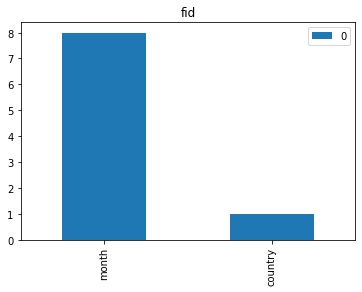

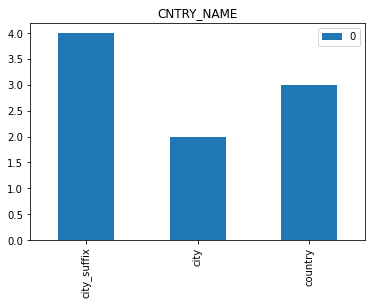

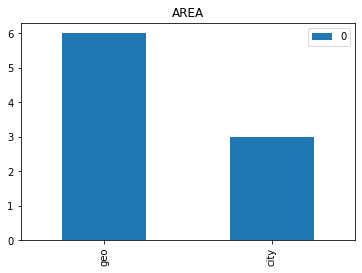

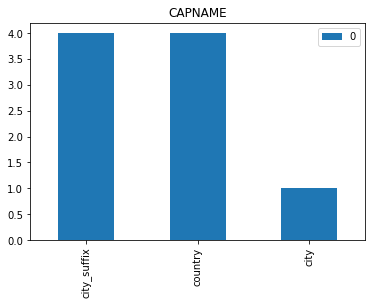

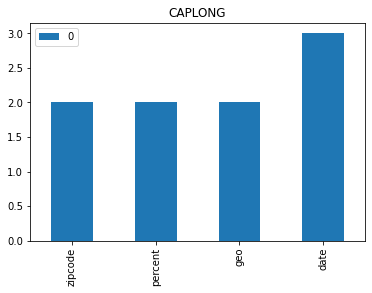

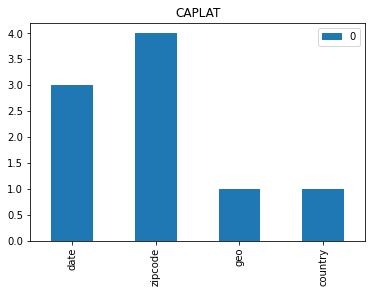

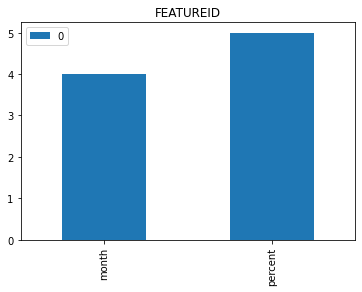

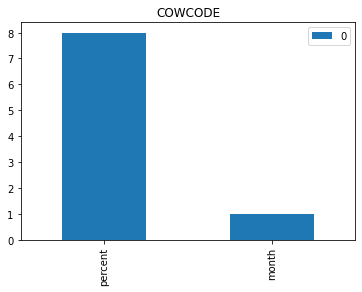

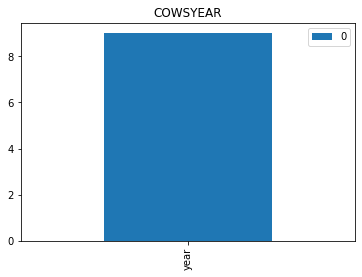

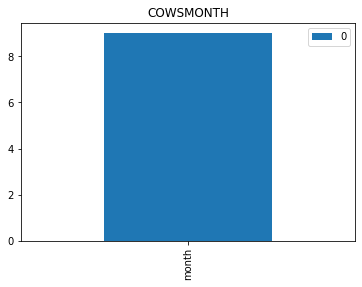

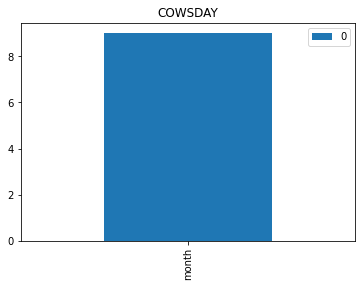

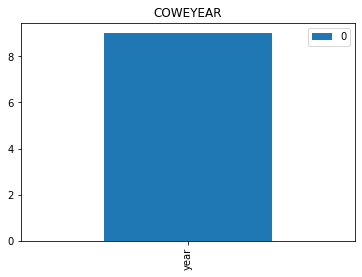

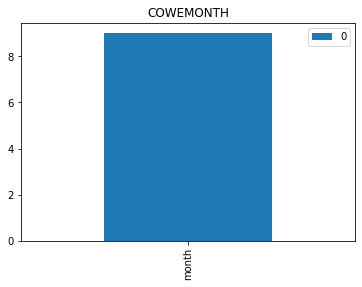

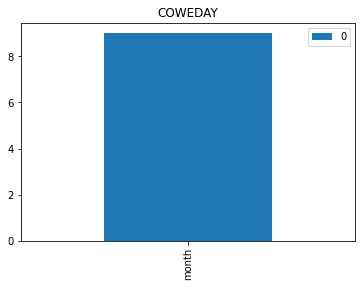

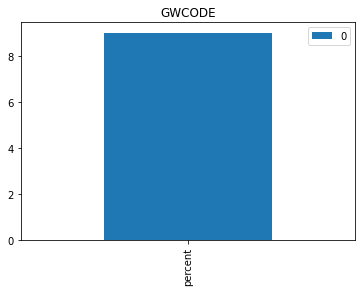

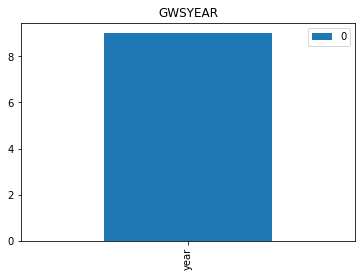

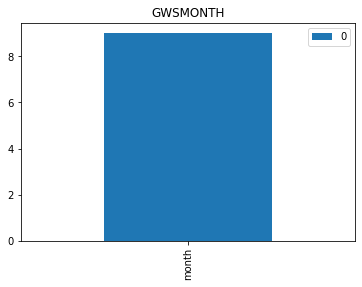

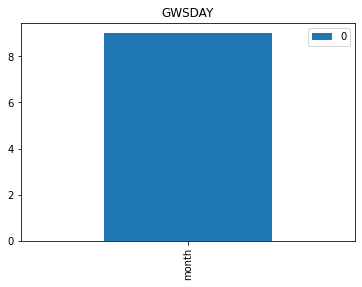

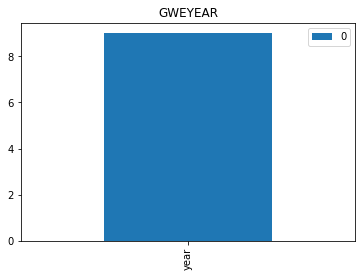

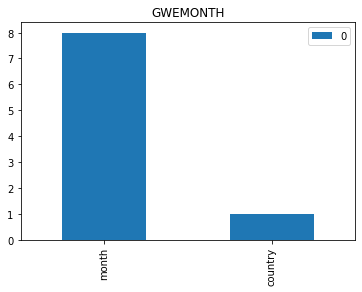

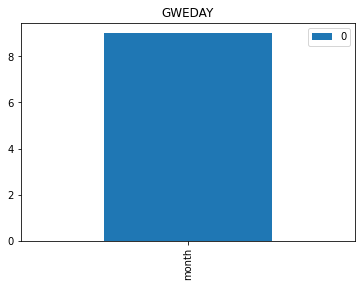

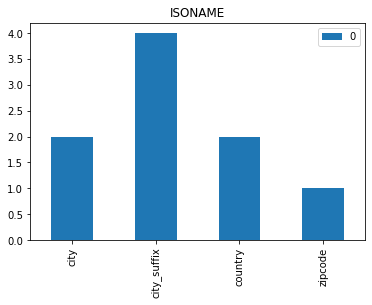

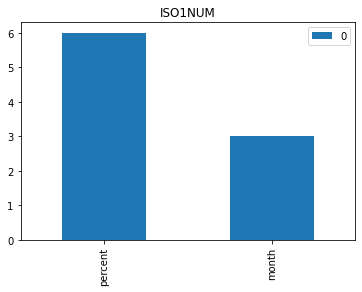

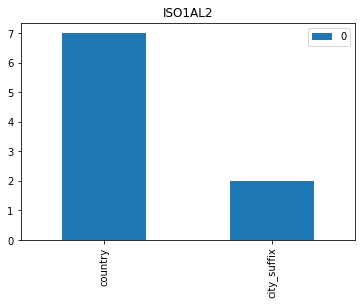

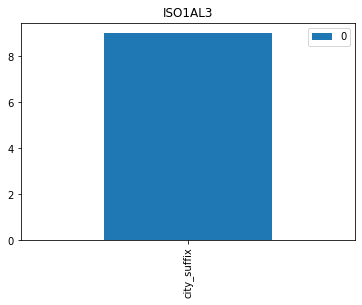

In [158]:
from collections import Counter
import pandas

for x in final:
#     print(x)
#     print(final[x])

    newData = Counter(final[x])
    df = pandas.DataFrame.from_dict(newData, orient='index')
    df.plot(kind='bar', title=x)
    # final['fid'].value_counts().plot()
    # Counter(final['fid']).keys() 
    # Counter(final['fid']).values() #

In [171]:
# create object with values
test_lines = {}
test_categories = data.columns

for category in test_categories:
    print(category)
    test_lines[category]=data[category]

# for column in data.columns:
#     print(column)
#     guesses=[]
#     for _ in range(1,10):
#         random_values = str(np.random.choice(data[column]))
#         random_col = column
#         print(random_values, random_col)

fid
CNTRY_NAME
AREA
CAPNAME
CAPLONG
CAPLAT
FEATUREID
COWCODE
COWSYEAR
COWSMONTH
COWSDAY
COWEYEAR
COWEMONTH
COWEDAY
GWCODE
GWSYEAR
GWSMONTH
GWSDAY
GWEYEAR
GWEMONTH
GWEDAY
ISONAME
ISO1NUM
ISO1AL2
ISO1AL3


In [160]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]



In [166]:
all_categories
n_categories = len(all_categories)

n_categories

10

In [233]:
category = randomChoice(test_categories)
line = randomChoice(list(test_lines[category]))
category_tensor = torch.tensor([list(test_categories).index(category)], dtype=torch.long)
category_tensor
line_tensor = lineToTensor(str(line))
line_tensor

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [234]:
def randomTrainingExample():
    category = randomChoice(test_categories)
    line = str(randomChoice(list(test_lines[category])))
    category_tensor = torch.tensor([list(test_categories).index(category)], dtype=torch.long)
    line_tensor = lineToTensor(str(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line, 'cat_tensor', category_tensor)

category = COWEDAY / line = 30 cat_tensor tensor([13])
category = CAPLONG / line = 44.18333 cat_tensor tensor([4])
category = fid / line = 47 cat_tensor tensor([0])
category = CAPNAME / line = Addis Ababa cat_tensor tensor([3])
category = fid / line = 4 cat_tensor tensor([0])
category = CNTRY_NAME / line = Ethiopia cat_tensor tensor([1])
category = ISO1AL2 / line = BJ cat_tensor tensor([23])
category = ISO1AL3 / line = TZA cat_tensor tensor([24])
category = CAPNAME / line = Banjul cat_tensor tensor([3])
category = CAPLAT / line = -17.8 cat_tensor tensor([5])


In [ ]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = list(all_categories).index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
